# Model 3
Train deep learning algorithm and predict SCF to use in `HMASR_30km_calibration.ipynb`

Env: `tf2_v0`

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf # Machine learning

In [2]:
conda list tensorflow

# packages in environment at /home/lalandmi/miniconda3/envs/tf2_v0:
#
# Name                    Version                   Build  Channel
tensorflow                2.7.0           cpu_py310hd1aba9c_0    conda-forge
tensorflow-base           2.7.0           cpu_py310h8d3bea7_0    conda-forge
tensorflow-estimator      2.7.0           cpu_py310hb7a2f4b_0    conda-forge

Note: you may need to restart the kernel to use updated packages.


## Load data

In [2]:
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_30km/'

# Snow depth
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_30km_WY*_SD_POST.nc')
sd = ds.SD_Post.load()

# SCF
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_30km_WY*_SWE_SCA_POST.nc')
swe = ds.SWE_Post.load()
scf= ds.SCA_Post.load()


# Mask
mask = xr.open_dataarray('Non_seasonal_snow_mask_30km.nc').load()

# Topo
# A remplacer par le fichier original en masquant les zones de neige permanente ?
latlim = slice(mask.lat.min().values.item(0)-0.5, mask.lat.max().values.item(0)+0.5)
lonlim = slice(mask.lon.min().values.item(0)-0.5, mask.lon.max().values.item(0)+0.5)

ds = xr.open_dataset('../data/HMASR_DEM_30km.nc')
topo = ds.elevation_seassnow.load()
topo_std = ds.std_seassnow.load()

In [3]:
sd['lat'] = mask.lat.values; sd['lon'] = mask.lon.values
swe['lat'] = mask.lat.values; swe['lon'] = mask.lon.values
scf['lat'] = mask.lat.values; scf['lon'] = mask.lon.values
topo['lat'] = mask.lat.values; topo['lon'] = mask.lon.values
topo_std['lat'] = mask.lat.values; topo_std['lon'] = mask.lon.values

## Make plot functions

### Compute weights
Taking into account:
- cos(lat)
- fraction of seasonal snow in a grid cell
- exclude cells with >30% of permanent snow

Weigths used to compute metrics (but not for optimization? -> maybe)

In [4]:
lat_weights = np.cos(np.deg2rad(scf.lat))
frac_seasonal_snow = (1-mask/100).where(scf[0]*0+1 == 1)
temp = (frac_seasonal_snow*lat_weights).where(mask<30)
weights = (temp / temp.sum()).fillna(0)
np.testing.assert_equal(weights.sum().values.item(0), 1)

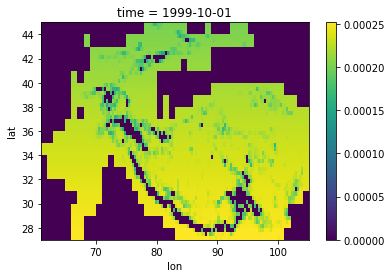

In [5]:
weights.plot()

In [6]:
train_period = slice('1999-10-01', '2013-09-30') # ~80%
val_period = slice('2013-10-01', '2017-09-30') # ~20%

## Machine learning

In [7]:
y_true = [[0., 1.], [0., 0.]]
y_pred = [[1., 1.], [1., 0.]]
# Using 'auto'/'sum_over_batch_size' reduction type.
mse = tf.keras.losses.MeanSquaredError()
mse(y_true, y_pred).numpy()
mse(y_true, y_pred, sample_weight=[0.7, 0.3]).numpy()

2022-05-04 17:13:35.412871: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.25

In [8]:
weights_ext = scf.copy()
for i in range(weights_ext.time.size):
    weights_ext[i] = weights
weights_ext = weights_ext.where(scf*0 == 0)

ds = scf.to_dataset(name='SCF')
ds['SD'] = sd
ds['SWE'] = swe
ds['STD'] = topo_std
ds['weights'] = weights_ext
ds

<xarray.Dataset>
Dimensions:  (lat: 54, lon: 132, time: 6575)
Coordinates:
  * lat      (lat) float64 27.17 27.5 27.83 28.17 ... 43.83 44.17 44.5 44.83
  * lon      (lon) float64 61.17 61.5 61.83 62.17 ... 103.8 104.2 104.5 104.8
  * time     (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2017-09-30
Data variables:
    SCF      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SD       (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SWE      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    STD      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    weights  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [9]:
df_train = ds.sel(time=train_period).to_dataframe()
df_test = ds.sel(time=val_period).to_dataframe()

In [10]:
df_train = df_train.dropna()
df_test = df_test.dropna()

df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

train_dataset = df_train[['SCF', 'SWE', 'SD', 'STD']]
test_dataset = df_test[['SCF', 'SWE', 'SD', 'STD']]

train_weights = df_train[['weights']]
test_weights = df_test[['weights']]

x_train = train_dataset.copy()
x_test = test_dataset.copy()

y_train = x_train.pop('SCF')
y_test = x_test.pop('SCF')

x_train_norm = (x_train - x_train.mean()) / x_train.std()
x_test_norm = (x_test - x_train.mean()) / x_train.std()

x_train_arr, y_train_arr = np.array(x_train_norm), np.array(y_train)
x_test_arr,  y_test_arr  = np.array(x_test_norm),  np.array(y_test)

In [11]:
def get_model_v1(shape):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape, name="InputLayer"))
    model.add(tf.keras.layers.Dense(16, activation='relu', name='Dense_n1'))
    model.add(tf.keras.layers.Dense(32, activation='relu', name='Dense_n2'))
    model.add(tf.keras.layers.Dense(16, activation='relu', name='Dense_n3'))
    
    # Output
    # The sigmoid actiavation allow to keep results between 0 and 1
    model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='Output'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse' )
    
    return model

In [12]:
input_size = len(x_train_arr[0])
model = get_model_v1( (input_size,) )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 16)                64        
                                                                 
 Dense_n2 (Dense)            (None, 32)                544       
                                                                 
 Dense_n3 (Dense)            (None, 16)                528       
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.load_weights('weights/scf_100km_ML3_weights.h5')

In [14]:
df = ds.to_dataframe()
df = df.dropna()
df.reset_index(inplace=True)
df_subset = df[['SCF', 'SWE', 'SD', 'STD']]
df_subset.pop('SCF')
df_val_norm = (df_subset - x_train.mean()) / x_train.std()
x_val_arr = np.array(df_val_norm)
y_out = model.predict(x_val_arr)

2022-05-04 17:16:36.854203: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 371382300 exceeds 10% of free system memory.
2022-05-04 17:16:37.183052: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 247588200 exceeds 10% of free system memory.
2022-05-04 17:16:37.211271: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 247588200 exceeds 10% of free system memory.
2022-05-04 17:16:37.369157: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 247588200 exceeds 10% of free system memory.
2022-05-04 17:23:08.150294: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 123794100 exceeds 10% of free system memory.


In [15]:
temp = ds.to_dataframe()
df_param = temp.dropna()
df_param['SCF'] = y_out
scf_param = xr.Dataset.from_dataframe(df_param).SCF.transpose("time", "lat", "lon")

/tmp/ipykernel_1031/2276827923.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_param['SCF'] = y_out


In [16]:
scf_param.to_netcdf('results/scf_30km_ML3.nc')

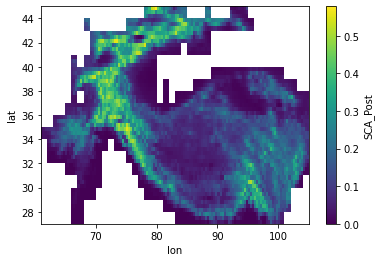

In [19]:
scf.mean('time').plot()

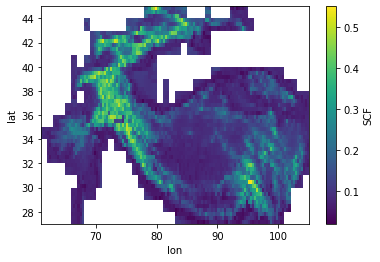

In [17]:
scf_param.mean('time').plot()